# <p style="text-align: center;"><strong>**“Red Wine Quality Prediction”**</strong></p>

**Data Analytics - Project**

Kacper Błachowiak, Jakub Ciura




## 1. Problem formulation

### 1.1 Project Goal

The project goal is to predict quality of variants of the Portuguese "Vinho Verde".
Prediction will be based on values of selected input variables such as: fixed acidity,
volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur
dioxide, density, pH, sulphates, alcohol. As a result system will determine quality of wine
and classify each to appropriate category (poor, excellent, etc.)

### 1.2 Purpose of Creating a Model and Potential Use Cases

The main goal of building a model using this dataset is to predict the quality of red wine based on its physicochemical properties. By analyzing these features, a predictive model can help estimate the wine quality score without the need for costly and time-consuming expert tastings.

Potential use cases include:

  -  Assisting winemakers in quality control by identifying batches with likely high or low quality before distribution.

- Supporting decisions in blending and production processes to improve overall wine quality.

- Enabling retailers and consumers to better understand and evaluate wine quality through data-driven insights.

- Serving as a benchmark for developing more advanced machine learning models in food and beverage quality assessment.

### 1.3 Source of the data and contents

The data comes from a public dataset available on Kaggle, based on research published by Cortez et al. in 2009. This dataset was created to analyze the quality of red wine based on various physicochemical properties.

It contains 1,599 samples of red wine, each described by 11 physicochemical features such as fixed acidity, volatile acidity, residual sugar, pH, sulfur dioxide levels, and alcohol content. Each sample is also assigned a quality score ranging from 0 to 10, given by expert tasters. The goal of this dataset is to enable analysis and modeling of the relationship between the chemical characteristics and the wine quality rating.

### 1.4 DAG

/tmp/ipykernel_5057/2580940403.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


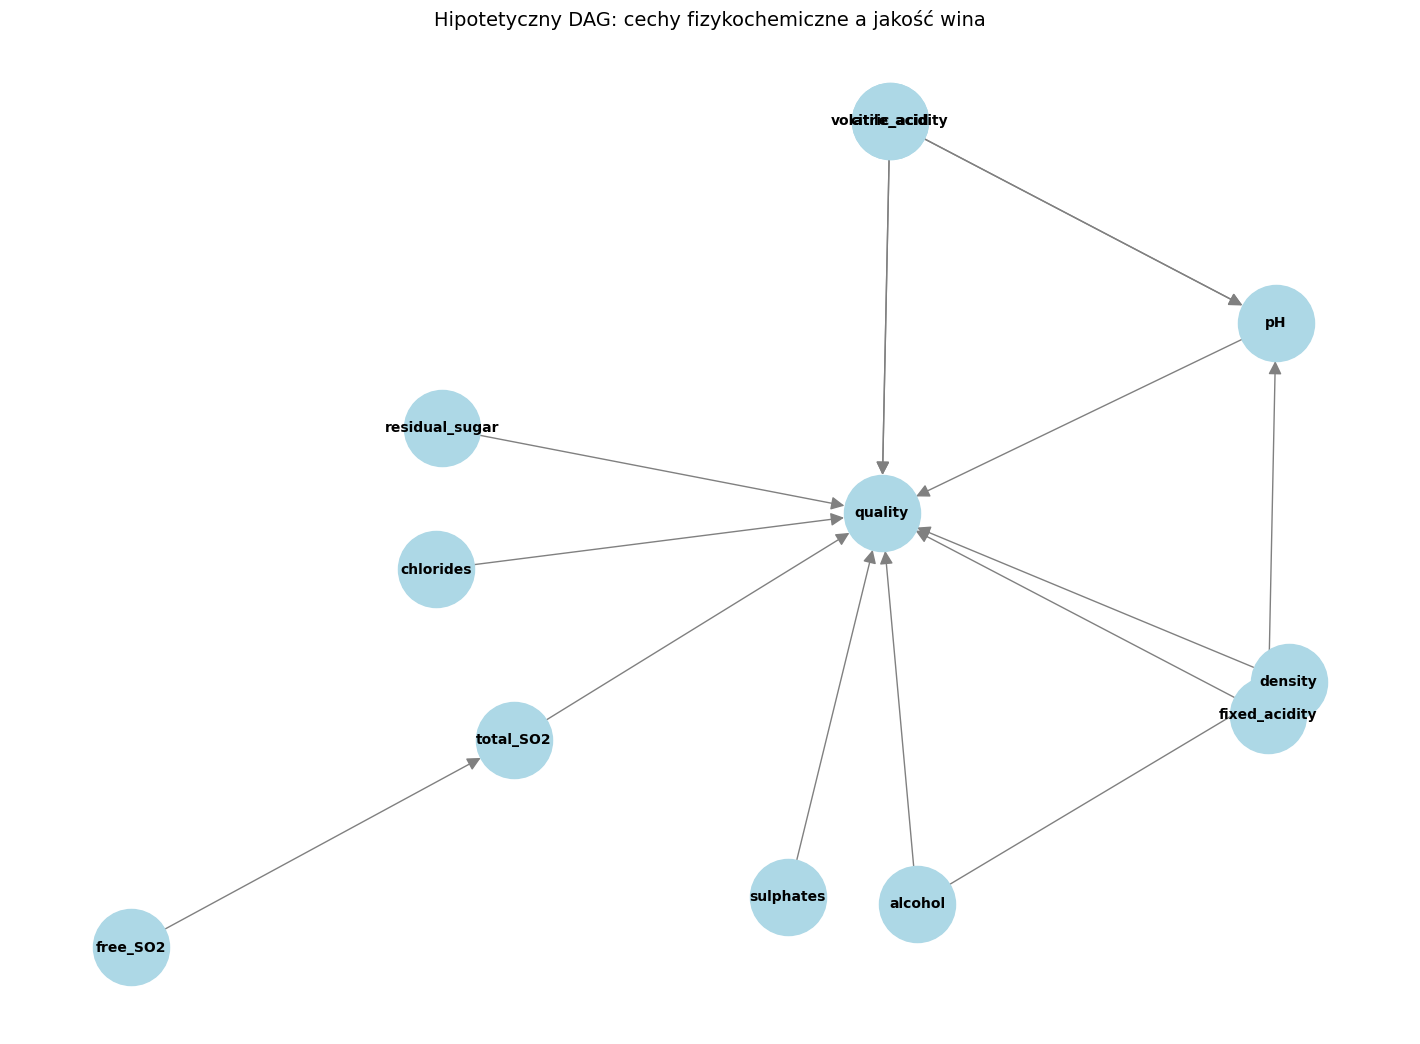

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. Tworzenie grafu DAG
G = nx.DiGraph()

edges = [
    ('fixed_acidity', 'pH'),
    ('volatile_acidity', 'pH'),
    ('citric_acid', 'pH'),
    ('citric_acid', 'quality'),
    ('residual_sugar', 'quality'),
    ('pH', 'quality'),
    ('chlorides', 'quality'),
    ('free_SO2', 'total_SO2'),
    ('total_SO2', 'quality'),
    ('sulphates', 'quality'),
    ('alcohol', 'quality'),
    ('alcohol', 'density'),
    ('density', 'quality'),
    ('fixed_acidity', 'quality'),
    ('volatile_acidity', 'quality'),
]

G.add_edges_from(edges)

# 2. Ustawienie layoutu
pos = nx.kamada_kawai_layout(G)  # Możesz też spróbować nx.spring_layout(G, k=1.5)

# 3. Rysowanie
plt.figure(figsize=(14, 10))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    node_size=3000,
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    arrowsize=20
)
plt.title("Hipotetyczny DAG: cechy fizykochemiczne a jakość wina", fontsize=14)
plt.tight_layout()
plt.show()


### 1.5 Confounding structures in the dataset

#### Fork

| Zależność                              | Opis                                             |
|----------------------------------------|--------------------------------------------------|
| `citric_acid ← pH → volatile_acidity` | pH jest wspólną przyczyną dwóch cech            |
| `pH ← fixed_acidity → quality`        | fixed_acidity wpływa na pH i na jakość          |
| `pH ← volatile_acidity → quality`     | volatile_acidity wpływa na pH i jakość          |
| `density ← alcohol → quality`         | alkohol wpływa na gęstość i jakość              |


####  Pipe

| Zależność                              | Opis                                                        |
|----------------------------------------|-------------------------------------------------------------|
| `citric_acid → pH → quality`          | pośredni wpływ kwasu cytrynowego na jakość przez pH         |
| `fixed_acidity → pH → quality`        | pH jest ogniwem między kwasowością a jakością               |
| `volatile_acidity → pH → quality`     | lotna kwasowość przez pH wpływa na jakość                   |
| `free_SO2 → total_SO2 → quality`      | suma SO₂ pośredniczy w wpływie wolnego SO₂                  |
| `alcohol → density → quality`         | gęstość jest ogniwem wpływu alkoholu na jakość              |



#### Collider

| Zależność                                   | Opis                                             |
|--------------------------------------------|--------------------------------------------------|
| `citric_acid → quality ← fixed_acidity`    | quality as a common result                      |
| `citric_acid → quality ← volatile_acidity` | quality as a common result                      |
| `residual_sugar → quality ← pH`            | quality as a common result                      |
| `chlorides → quality ← pH`                 | quality as a common result                      |
| `total_SO2 → quality ← sulphates`          | quality as a common result                      |
| `alcohol → quality ← sulphates`            | quality as a common result                      |
| `density → quality ← alcohol`              | quality as a common result                      |
| `density → quality ← pH`                   | quality as a common result                      |


## 2. Data preprocessing ------------ chage of boxplots - need to be seperated onto many diagrams (each seperate scale)

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Descriptive statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000    

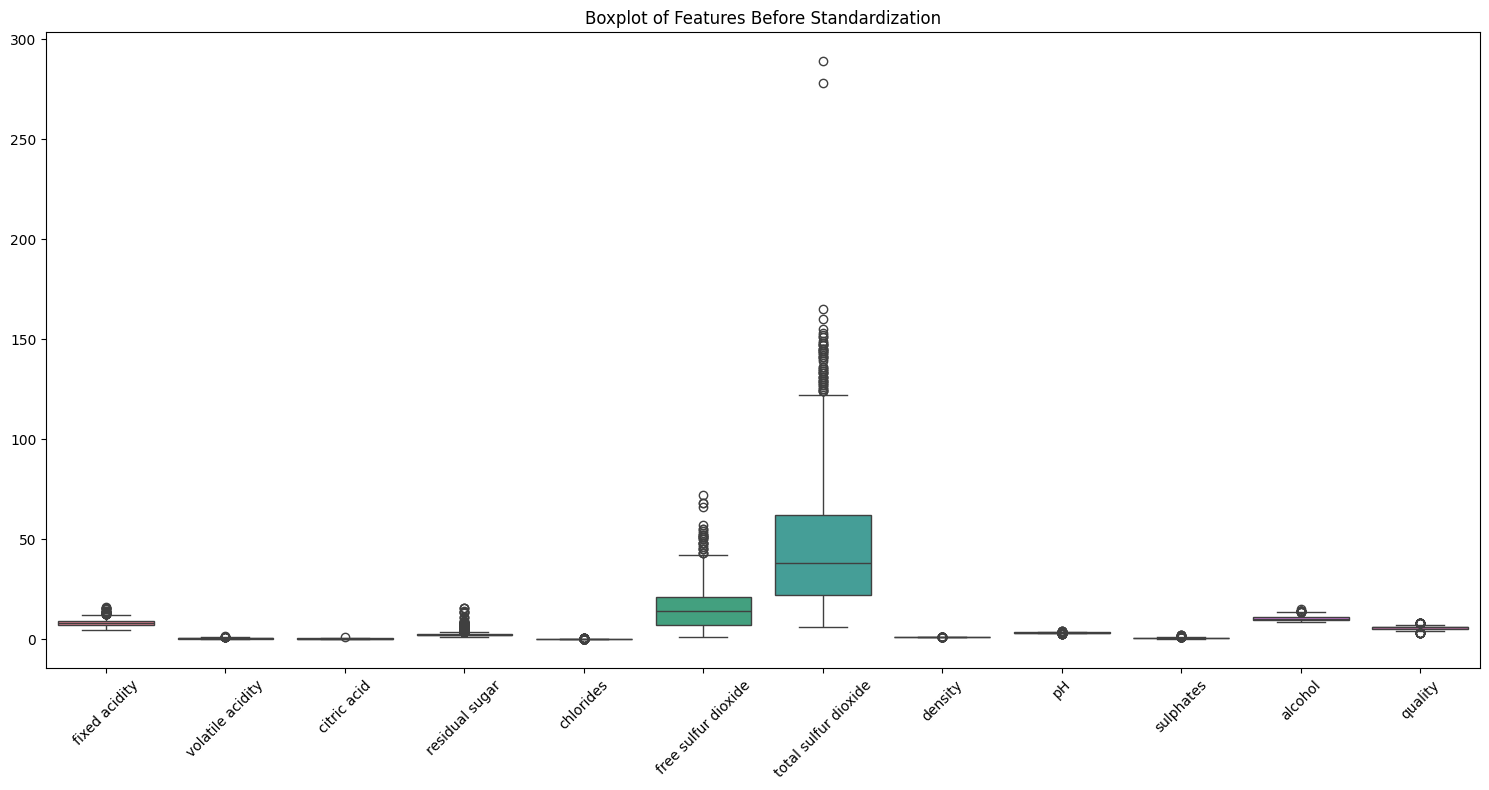

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv("projekt/data/winequality-red.csv")

# --- 1. Sprawdzenie braków danych ---
print("Missing values per column:")
print(df.isnull().sum())

# --- 2. Statystyki opisowe ---
print("\nDescriptive statistics:")
print(df.describe())

# --- 3. Wykrywanie outlierów (np. za pomocą z-score) ---
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)

print("\nNumber of outliers per column (|z| > 3):")
print(outliers)

# Opcjonalnie: wizualizacja boxplotami
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features Before Standardization")
plt.tight_layout()
plt.show()

# --- 4. Standaryzacja danych ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("quality", axis=1))

X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1])
y = df["quality"]

All of samples are fully described (all columns filled)

Outlier analysis indicated that several features (e.g., total sulfur dioxide, residual sugar) contain extreme values based on z-score > 3. However, these values were retained, as they fall within chemically plausible ranges and reflect naturally occurring variation in wine production practices.


Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Descriptive statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000    

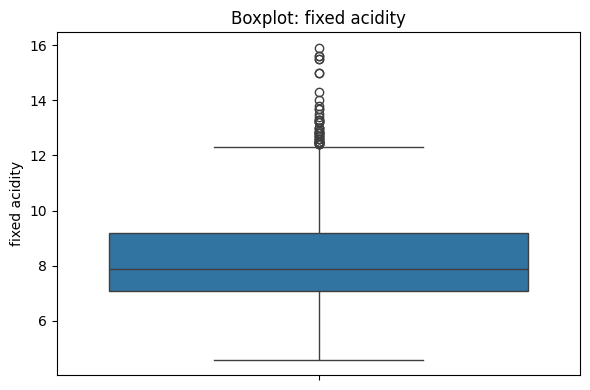

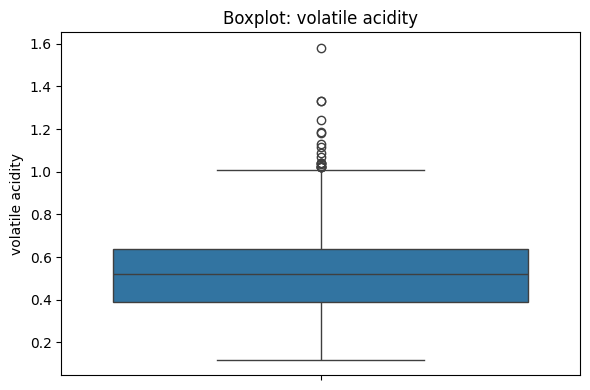

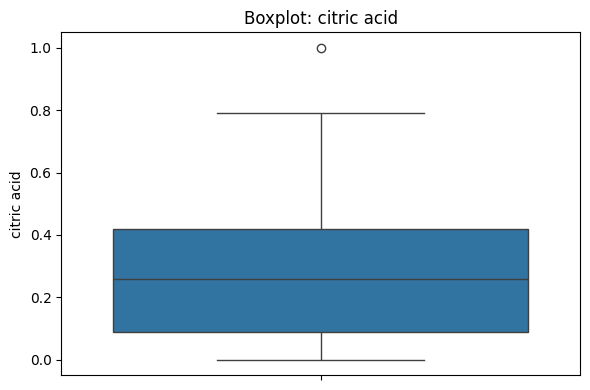

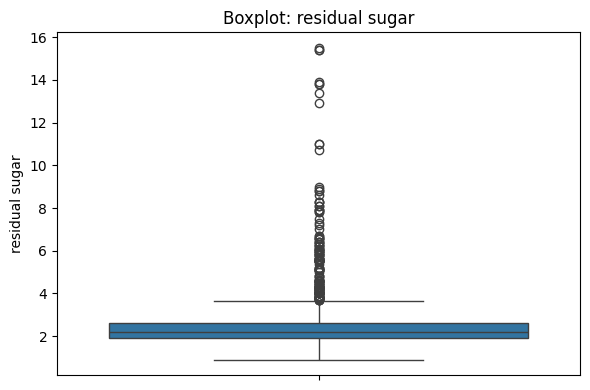

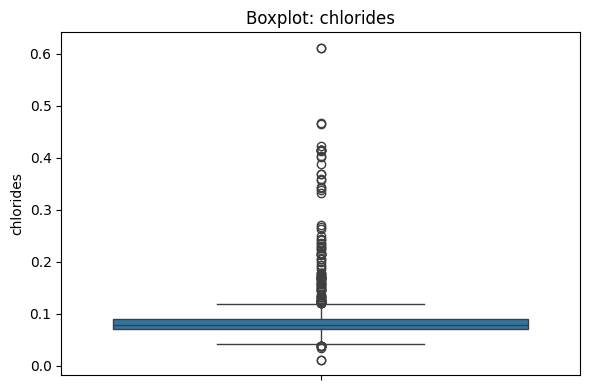

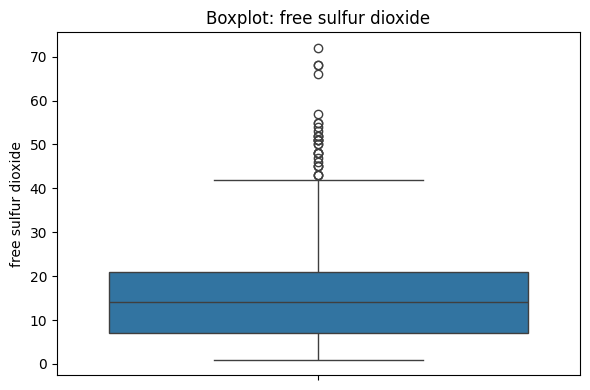

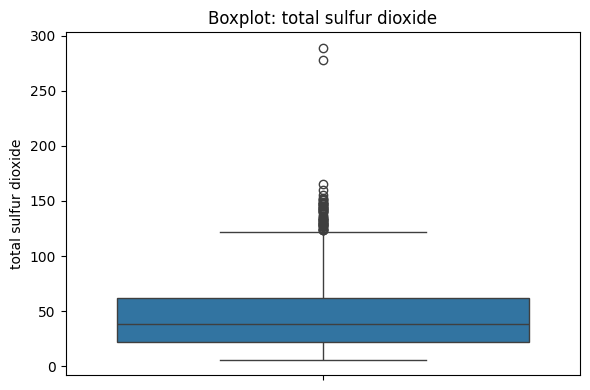

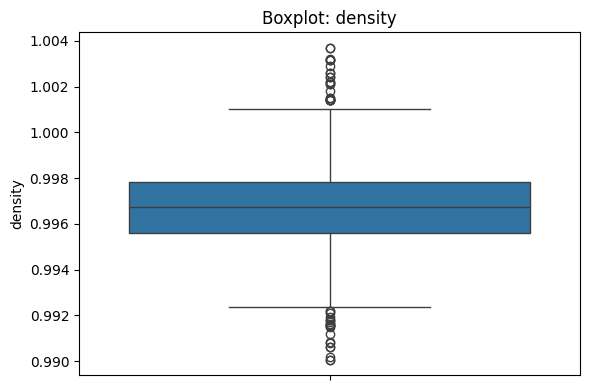

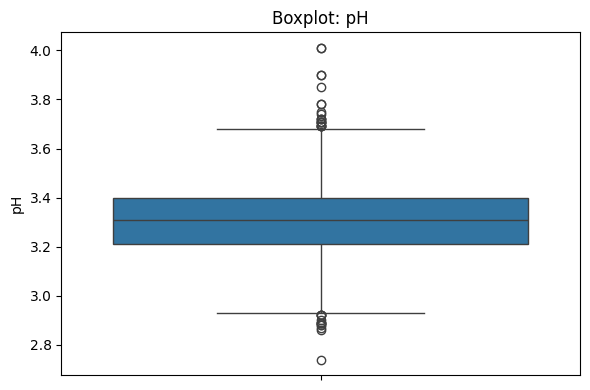

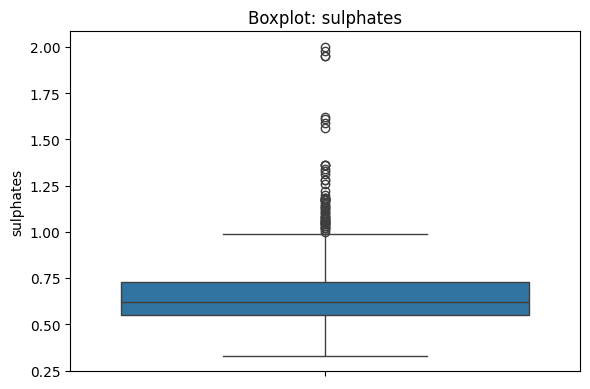

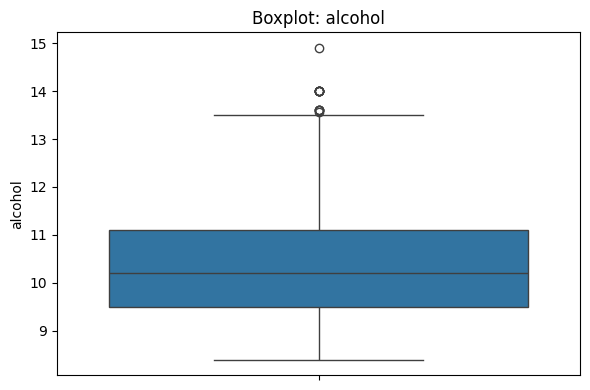

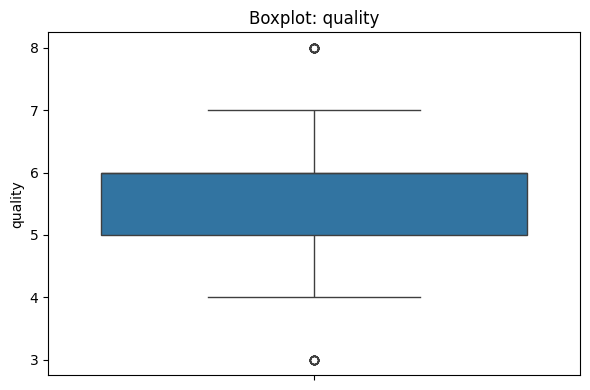

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv("projekt/data/winequality-red.csv")

# --- 1. Sprawdzenie braków danych ---
print("Missing values per column:")
print(df.isnull().sum())

# --- 2. Statystyki opisowe ---
print("\nDescriptive statistics:")
print(df.describe())

# --- 3. Wykrywanie outlierów (np. za pomocą z-score) ---
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)

print("\nNumber of outliers per column (|z| > 3):")
print(outliers)

# Osobne boxploty dla każdej zmiennej (ze względu na różne skale)
numeric_columns = df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


# --- 4. Standaryzacja danych ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("quality", axis=1))

X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1])
y = df["quality"]

Checking the correlation of predictors

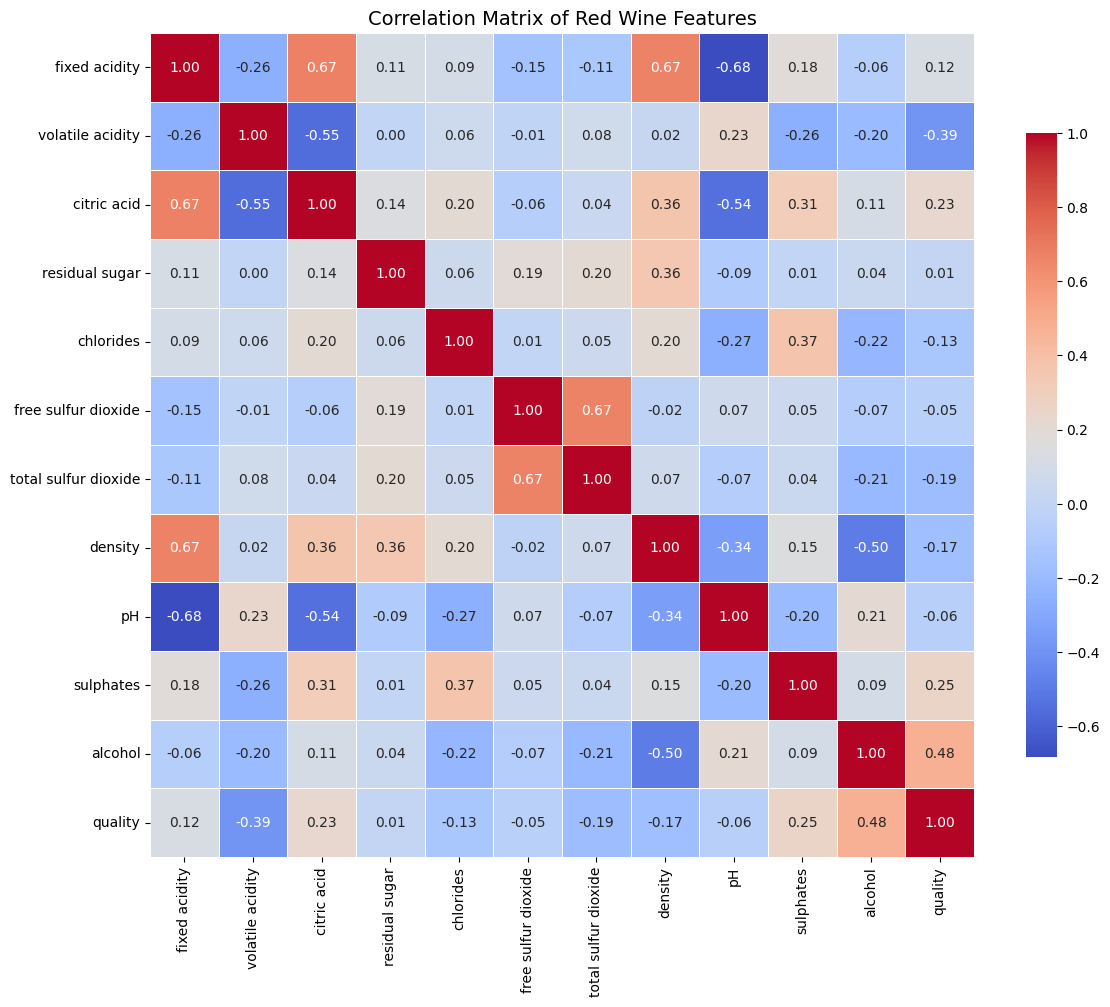

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór tylko zmiennych liczbowych
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Obliczenie macierzy korelacji (Pearson)
correlation_matrix = numeric_features.corr(method='pearson')

# Wizualizacja
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .75}
)
plt.title("Correlation Matrix of Red Wine Features", fontsize=14)
plt.tight_layout()
plt.show()


Conclusions^

Great correlation with target (quality):
- alcohol	+0.48	najsilniejsza pozytywna korelacja – warto uwzględnić
- volatile acidity	-0.39	dość silna negatywna korelacja – warto uwzględnić
- sulphates	+0.25	umiarkowana korelacja – można uwzględnić
- citric acid	+0.23	umiarkowana – można rozważyć
- density	-0.17	słaba korelacja – ale może być problem kolinearności

High correlation between features:
- density vs residual sugar: +0.36
- fixed acidity vs citric acid: +0.67
- total sulfur dioxide vs free sulfur dioxide: +0.67
- density vs fixed acidity: +0.67
- pH vs fixed acidity: -0.68


Due to above, **basic model** consists of predictors: alcohol, volatile acidity and sulphates.

Additionally, it **second version of model** may be extended with citric acid and density.


Train-test split

In [5]:
'''# --- 5. Podział na zbiór treningowy i testowy ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")'''


'# --- 5. Podział na zbiór treningowy i testowy ---\nX_train, X_test, y_train, y_test = train_test_split(\n    X_scaled_df, y, test_size=0.2, random_state=42\n)\n\nprint(f"\nTraining samples: {X_train.shape[0]}")\nprint(f"Test samples: {X_test.shape[0]}")'

## **3. Models**

### 3.1 Model 1

Creating data, which consists of predictors: *alcohol, volatile acidity, sulphates*.

In [6]:
# Wybrane predyktory do modelu 1
selected_predictors = ["alcohol", "volatile acidity", "sulphates"]

# Standaryzacja tylko wybranych predyktorów
X_selected = df[selected_predictors].values
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

# Target
X_train, X_test, y_train, y_test = train_test_split(X_scaled_selected, y, test_size=0.2, random_state=42)

stan_data = {
    "N": X_train.shape[0],
    "K": X_train.shape[1],
    "X": X_train,
    "y": y_train
}


In [7]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_1.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

21:41:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:13 - cmdstanpy - INFO - CmdStan done processing.



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -135.902000  0.033751  1.553870  1.393640 -138.837000 -135.590000   
alpha      5.625870  0.000277  0.019083  0.019348    5.594740    5.625770   
beta[1]    0.330912  0.000284  0.019269  0.019012    0.299133    0.331174   
beta[2]   -0.207401  0.000284  0.019464  0.019641   -0.239635   -0.207851   
beta[3]    0.105873  0.000268  0.018660  0.018559    0.075377    0.105691   
sigma      0.665749  0.000192  0.012852  0.012687    0.644979    0.665455   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__    -134.015000   2079.51   3201.85  1.000820  
alpha      5.657550   4766.69   2801.25  0.999716  
beta[1]    0.361836   4644.48   3120.15  1.000320  
beta[2]   -0.175231   4776.62   3058.50  1.000810  
beta[3]    0.136668   4898.35   3477.77  1.000410  
sigma      0.687448   4566.29   2937.46  1.002790  


#### Prior predictive check - model 1_1

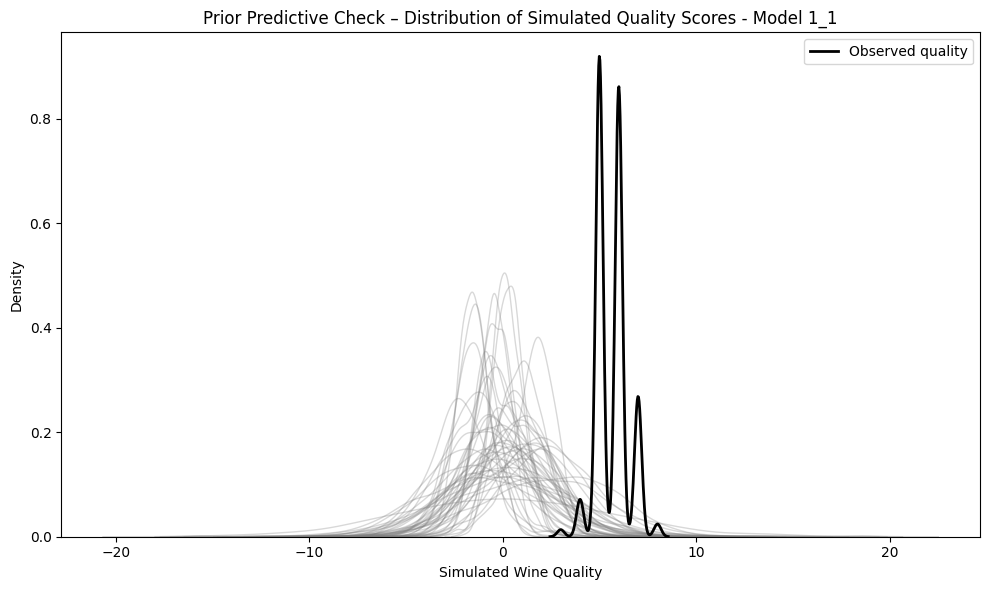

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=0, scale=1, size=n_samples)
beta_prior = np.random.normal(loc=0, scale=1, size=(n_samples, 3))  # 3 predyktory
sigma_prior = np.random.exponential(scale=1.0, size=n_samples)

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores - Model 1_1")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


We can see, that simulated quality scores doesn't make sense - should be between 3 to 8. Let's create a new version of model: *model1_2.stan*

### 3.2 Model 1_2

In [9]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_2.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

21:41:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:14 - cmdstanpy - INFO - CmdStan done processing.
21:41:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



             Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__    -2.479080  0.044395  1.673210  1.497540 -5.737960 -2.137430 -0.433986   
alpha    5.503520  0.015905  1.005690  1.020730  3.855590  5.509620  7.161210   
beta[1] -0.001129  0.007865  0.493870  0.496750 -0.798055 -0.007143  0.817549   
beta[2] -0.002161  0.007974  0.491185  0.495737 -0.811438 -0.000422  0.813447   
beta[3] -0.006525  0.008947  0.515472  0.509632 -0.860668 -0.002643  0.834715   
sigma    0.796666  0.010945  0.607579  0.604405  0.051547  0.673546  1.984840   

         ESS_bulk  ESS_tail    R_hat  
lp__      1470.03   2235.43  1.00120  
alpha     4007.16   2594.43  1.00172  
beta[1]   3949.20   2814.48  1.00053  
beta[2]   3794.10   2692.69  1.00263  
beta[3]   3370.46   2692.59  1.00054  
sigma     1943.20   1248.02  1.00374  


#### Prior predictive check - model 1_2

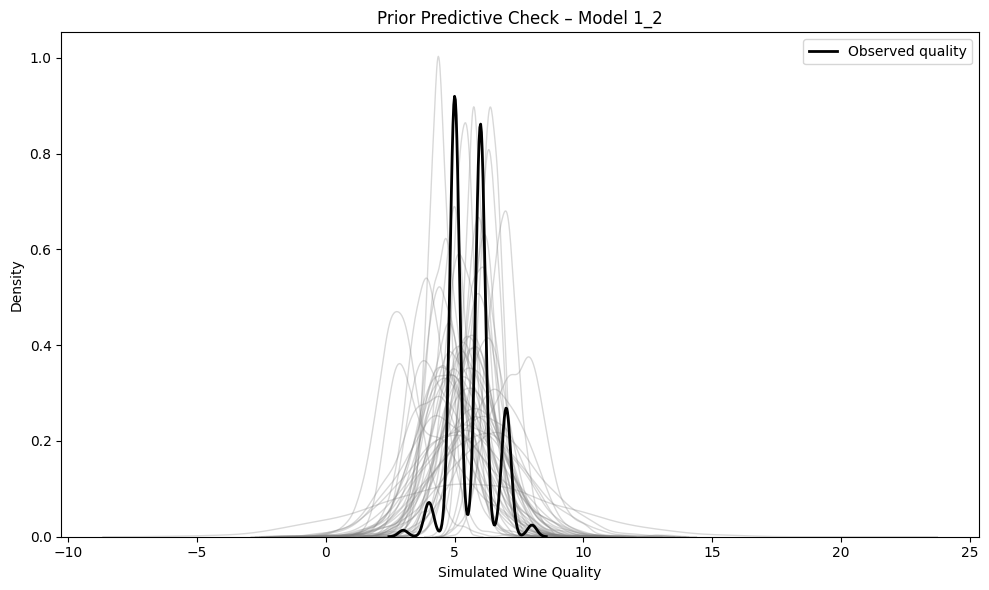

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check – Model 1_2")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

After adjusting our priors to be more informative (centered around expected quality levels and with reduced variance), the prior predictive check showed that the simulated data aligns well with the observed range of wine quality (mostly between 3 and 8). This confirms that our prior beliefs do not produce implausible outputs and are suitable for further posterior inference.

#### Posterior distribution check - model 1_2

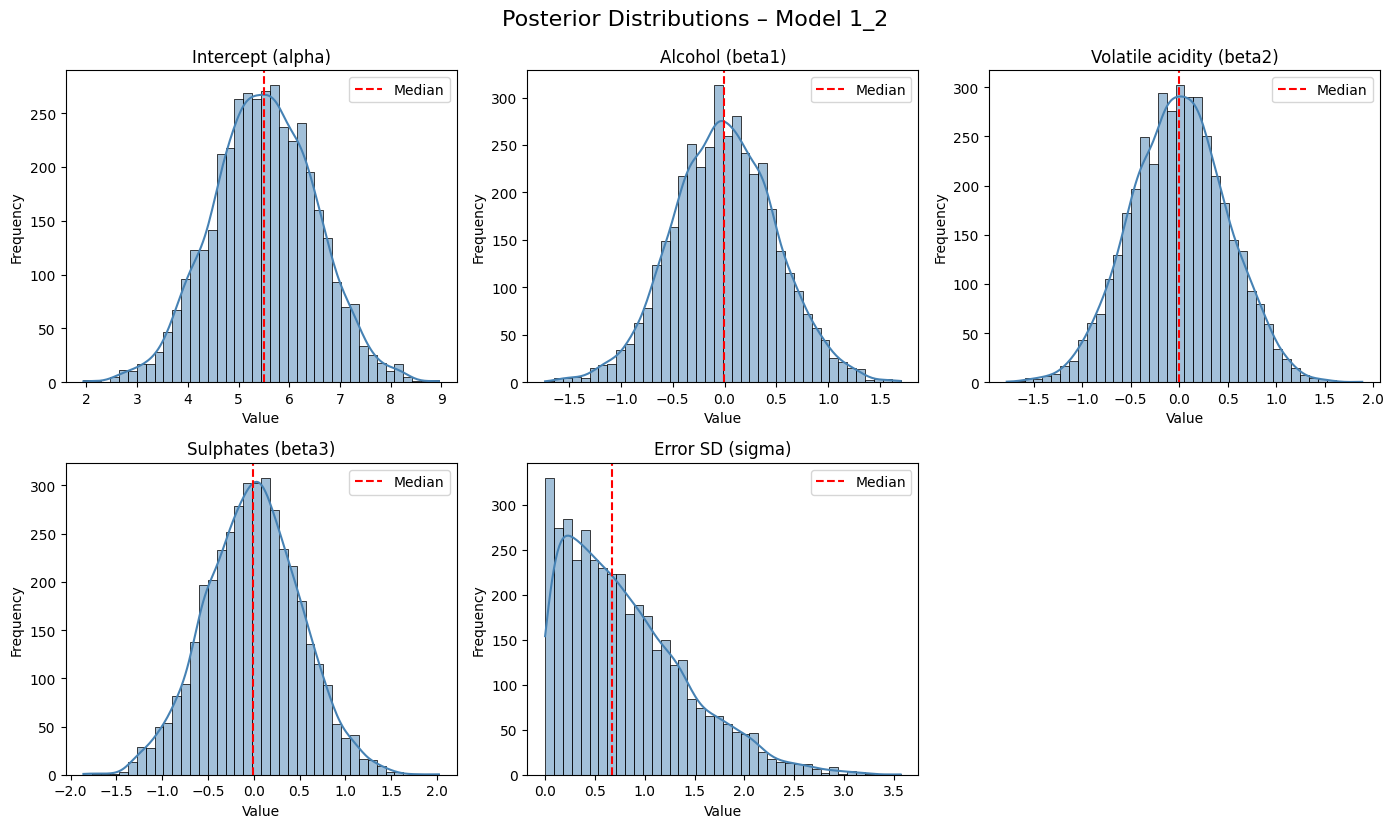

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pobranie danych posteriorów jako DataFrame
posterior_df = fit.draws_pd()

# Lista parametrów do wizualizacji
param_names = ['alpha', 'beta[1]', 'beta[2]', 'beta[3]', 'sigma']
param_labels = {
    'alpha': 'Intercept (alpha)',
    'beta[1]': 'Alcohol (beta1)',
    'beta[2]': 'Volatile acidity (beta2)',
    'beta[3]': 'Sulphates (beta3)',
    'sigma': 'Error SD (sigma)'
}

# Tworzenie wykresów
plt.figure(figsize=(14, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=40, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels[param])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_2", fontsize=16, y=1.03)
plt.show()

The posterior distributions for Model 1.2 indicate that alcohol content has the strongest positive association with wine quality, while volatile acidity appears to slightly reduce it. Sulphates have a weak positive effect, but the posterior is still close to zero, suggesting limited evidence for strong influence. The posterior for sigma shows a low residual variance, indicating that the model fits the data fairly well.

#### Posterior predictive check - model 1_2

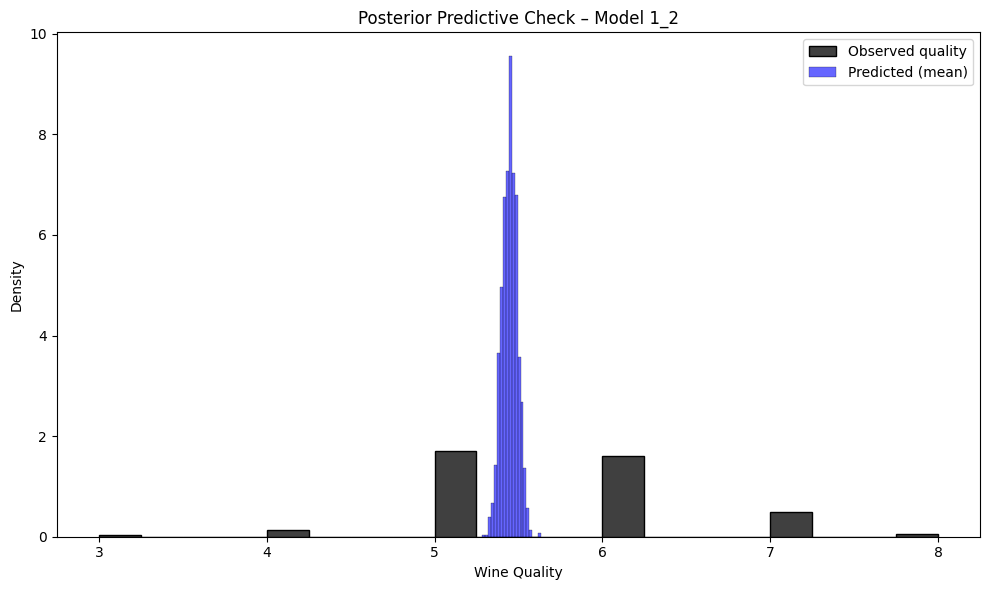

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Wyciąganie próbek z posteriora
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Użyj np. 500 losowych próbek do predykcji
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Konwersja do tablicy: (n_draws x n_observations)
y_pred_samples = np.array(y_pred_samples)

# PPC: rozkład danych obserwowanych vs. predykowanych
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=20, color="black", label="Observed quality", stat="density")
sns.histplot(y_pred_samples.mean(axis=0), bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density")

plt.title("Posterior Predictive Check – Model 1_2")
plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


While the model captured the central tendency of wine quality well, the posterior predictive check revealed that the predicted values are overly concentrated and do not reflect the actual spread of the data. This suggests underfitting or a lack of sufficient explanatory variables. A second model will be introduced to address this issue.

### 3.3 Model1_3

To improve flexibility of model, the new version was created: *model1_3.stan*.

In [13]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_3.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

21:41:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:17 - cmdstanpy - INFO - CmdStan done processing.



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -119.760000  0.032689  1.536190  1.389200 -122.707000 -119.460000   
alpha      5.627580  0.000293  0.018941  0.019341    5.596980    5.627530   
beta[1]    0.331358  0.000292  0.019322  0.019301    0.300160    0.331263   
beta[2]   -0.207361  0.000317  0.019395  0.019240   -0.239898   -0.207305   
beta[3]    0.105348  0.000290  0.018672  0.018794    0.074964    0.105363   
sigma      0.665992  0.000189  0.013328  0.013517    0.644108    0.666014   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__    -117.845000   2225.02   2983.23  1.001400  
alpha      5.658670   4417.15   3007.92  0.999845  
beta[1]    0.363715   4448.55   3255.65  1.001020  
beta[2]   -0.175376   3818.18   3423.25  1.001270  
beta[3]    0.136074   4235.75   3276.72  1.000500  
sigma      0.688018   4935.58   3084.95  1.001940  


#### Prior predictive check - model 1_3

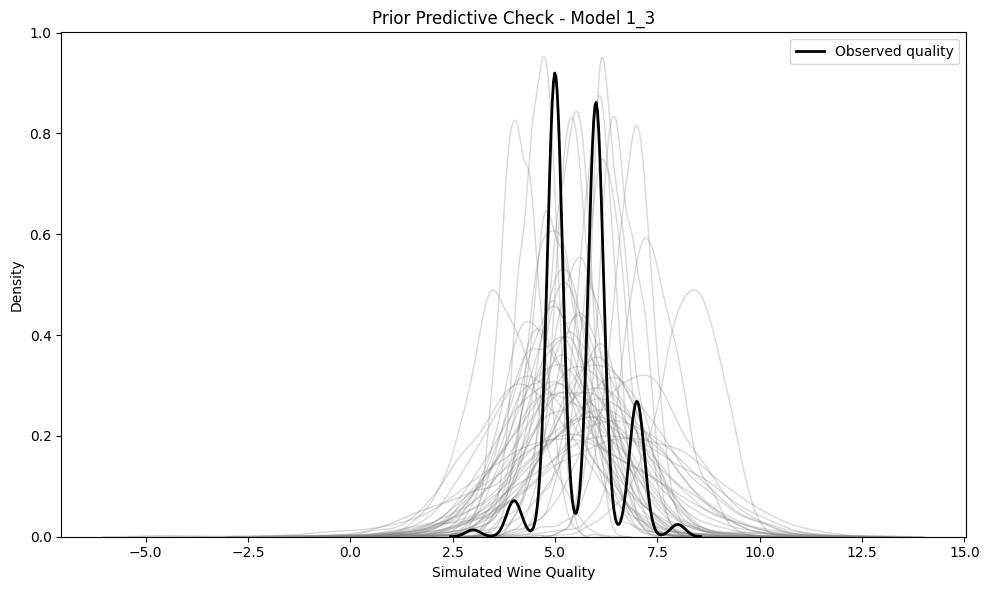

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check - Model 1_3")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

#### Posterior distribution check - model 1_3

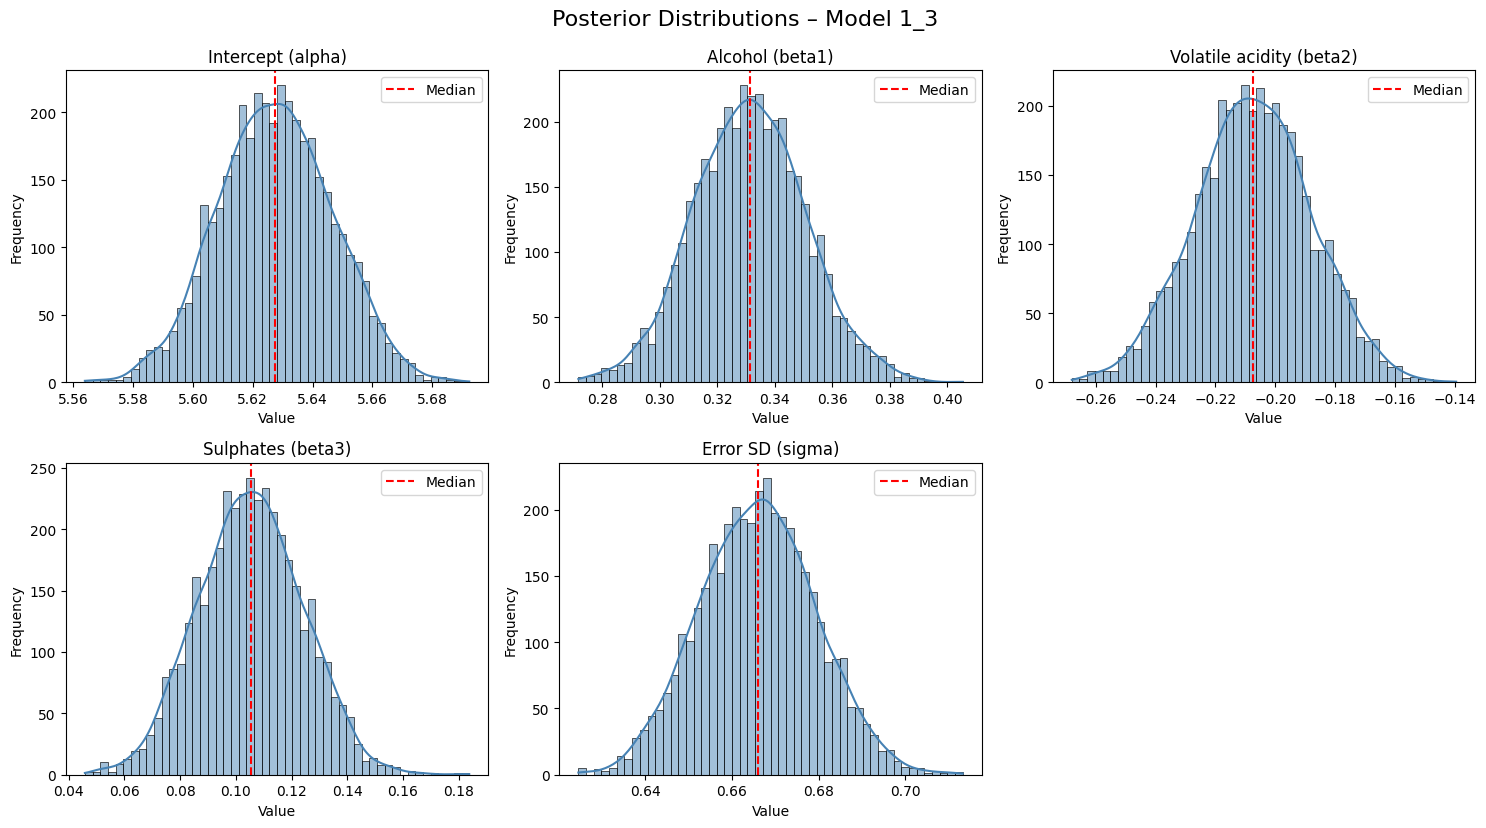

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Zakładamy, że fit to wynik modelu 1_3
posterior_df = fit.draws_pd()

# Lista parametrów, dopasowana do obecnego modelu
param_names = [col for col in posterior_df.columns if col.startswith("alpha") or col.startswith("beta") or col == "sigma"]


# Przyjazne nazwy do wykresów
param_labels = {
    "alpha": "Intercept (alpha)",
    "beta[1]": "Alcohol (beta1)",
    "beta[2]": "Volatile acidity (beta2)",
    "beta[3]": "Sulphates (beta3)",
    "sigma": "Error SD (sigma)"
}

# Tworzenie wykresów
plt.figure(figsize=(15, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=50, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels.get(param, param))  # fallback jeśli czegoś brakuje
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_3", fontsize=16, y=1.03)
plt.show()


#### Posterior predictive check - model 1_3

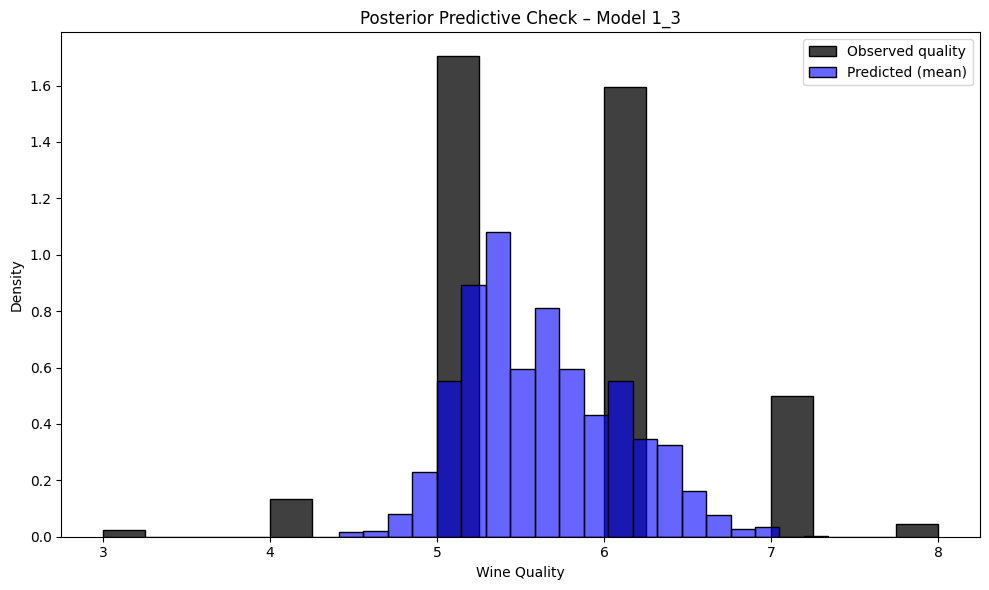

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Wyciąganie próbek z posteriora
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Użyj np. 500 losowych próbek do predykcji
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Konwersja do tablicy: (n_draws x n_observations)
y_pred_samples = np.array(y_pred_samples)

# PPC: rozkład danych obserwowanych vs. predykowanych
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=20, color="black", label="Observed quality", stat="density")
sns.histplot(y_pred_samples.mean(axis=0), bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density")

plt.title("Posterior Predictive Check – Model 1_3")
plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


The revised Model 1.3 with more flexible priors better reflects the observed variability in wine quality. The posterior predictive distribution is now wider and more aligned with the empirical distribution. However, the model still underestimates the tails, indicating that additional explanatory variables may be required — this will be addressed in Model 2.

Posterior Predictive Check – TEST SET (Model 1_3):

Test sample #11


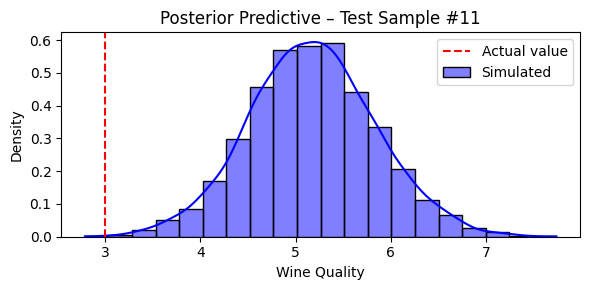

Test sample #208


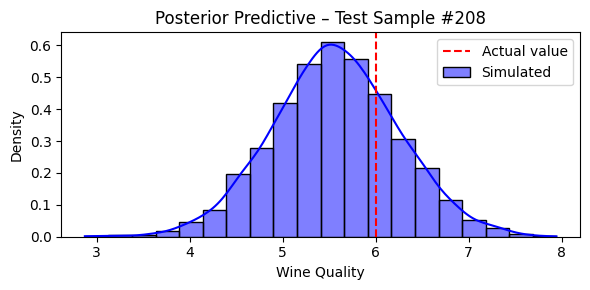

Test sample #176


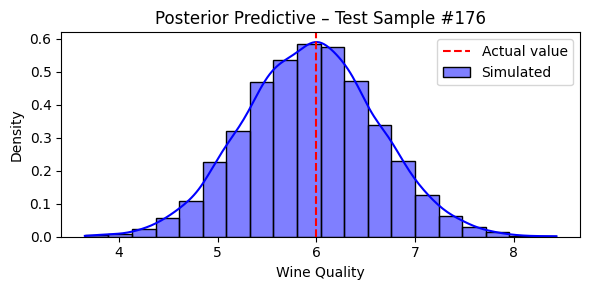

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Załaduj próbki z posteriora dla modelu 1_3 (fit1)
posterior_df_1 = fit.draws_pd()
alpha_samples = posterior_df_1["alpha"].values
sigma_samples = posterior_df_1["sigma"].values
beta_samples = posterior_df_1[[f"beta[{i}]" for i in range(1, X_test.shape[1] + 1)]].values

print("Posterior Predictive Check – TEST SET (Model 1_3):\n")

for i in range(3):
    idx = random.randint(0, len(X_test) - 1)
    print(f"Test sample #{idx}")

    mu_i = X_test[idx] @ beta_samples.T + alpha_samples
    y_sim_i = np.random.normal(mu_i, sigma_samples)

    plt.figure(figsize=(6, 3))
    sns.histplot(y_sim_i, bins=20, kde=True, color='blue', stat="density", label='Simulated')
    plt.axvline(y_test.iloc[idx], color='red', linestyle='--', label='Actual value')
    plt.title(f'Posterior Predictive – Test Sample #{idx}')
    plt.xlabel("Wine Quality")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
y_pred_samples_test = []

for i in range(len(alpha_samples)):
    mu_test = X_test @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu_test, sigma_samples[i])
    y_pred_samples_test.append(y_sim)

y_pred_samples_test = np.array(y_pred_samples_test)
y_pred_mean_test = y_pred_samples_test.mean(axis=0)

accuracy_model1_test = np.mean(np.round(y_pred_mean_test) == np.round(y_test))
print(f"Accuracy (Model 1, on test set): {accuracy_model1_test:.3f}")

Accuracy (Model 1, on test set): 0.553


### 3.4 Model 2

Implementing version close to Model1_3, but with 5 predictors - added citric acid and density.

In [19]:
# Nowy zestaw predyktorów
predictors_model2 = ["alcohol", "volatile acidity", "sulphates", "citric acid", "density"]

# Standaryzacja
X_model2 = df[predictors_model2].values
scaler2 = StandardScaler()
X_scaled_model2 = scaler2.fit_transform(X_model2)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_model2, y, test_size=0.2, random_state=42)

stan_data2 = {
    "N": X_train.shape[0],
    "K": X_train.shape[1],
    "X": X_train,
    "y": y_train
}


In [20]:
from cmdstanpy import CmdStanModel

model2 = CmdStanModel(stan_file="projekt/models/model2_1.stan")

fit2 = model2.sample(
    data=stan_data2,
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit2.summary())


21:41:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:22 - cmdstanpy - INFO - CmdStan done processing.
21:41:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -119.738000  0.044745  1.878070  1.732420 -123.268000 -119.368000   
alpha      5.627570  0.000235  0.019091  0.018784    5.596850    5.627740   
beta[1]    0.347535  0.000364  0.022833  0.022678    0.309944    0.347584   
beta[2]   -0.221263  0.000353  0.023328  0.023613   -0.259627   -0.221392   
beta[3]    0.105399  0.000246  0.019517  0.019254    0.073456    0.105598   
beta[4]   -0.029927  0.000437  0.025880  0.025851   -0.072534   -0.029646   
beta[5]    0.034899  0.000434  0.025072  0.025499   -0.006869    0.035354   
sigma      0.665888  0.000171  0.013090  0.013665    0.644500    0.665710   

                95%  ESS_bulk  ESS_tail    R_hat  
lp__    -117.354000   1777.37   2658.02  1.00058  
alpha      5.658910   6763.48   3108.04  1.00156  
beta[1]    0.385939   3974.15   2930.71  1.00088  
beta[2]   -0.183026   4413.14   3362.83  1.00022  
beta[3]    0.136462   6445.49   2956.51  1.00230  

#### Prior predictive check - model 2_1

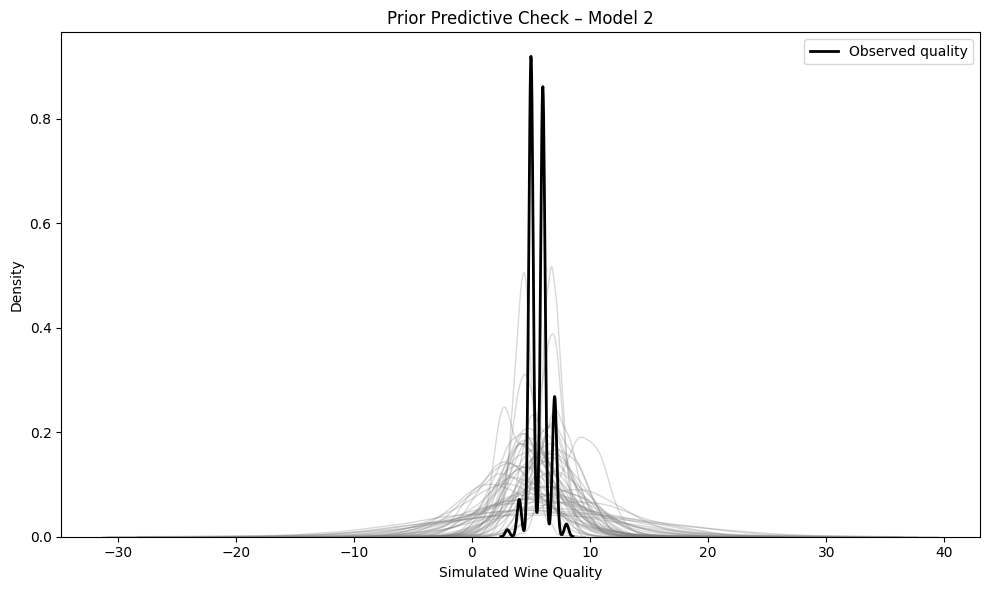

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prior predictive check for Model 2 (5 predictors) ---
n_samples = 500  # liczba prób
n_obs = X_scaled_model2.shape[0]

# Priory z model2_1.stan
alpha_prior = np.random.normal(loc=5.5, scale=1.5, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, 5))  # 5 predyktorów
sigma_prior = np.random.exponential(scale=2.0, size=n_samples)  # więcej wariancji

# Symulacje
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_model2 @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

y_prior_samples = np.array(y_prior_samples)

# Wykres
plt.figure(figsize=(10, 6))
for i in range(50):  # tylko kilkanaście-50 krzywych
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check – Model 2")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


#### Posterior distribution check - model 2_1

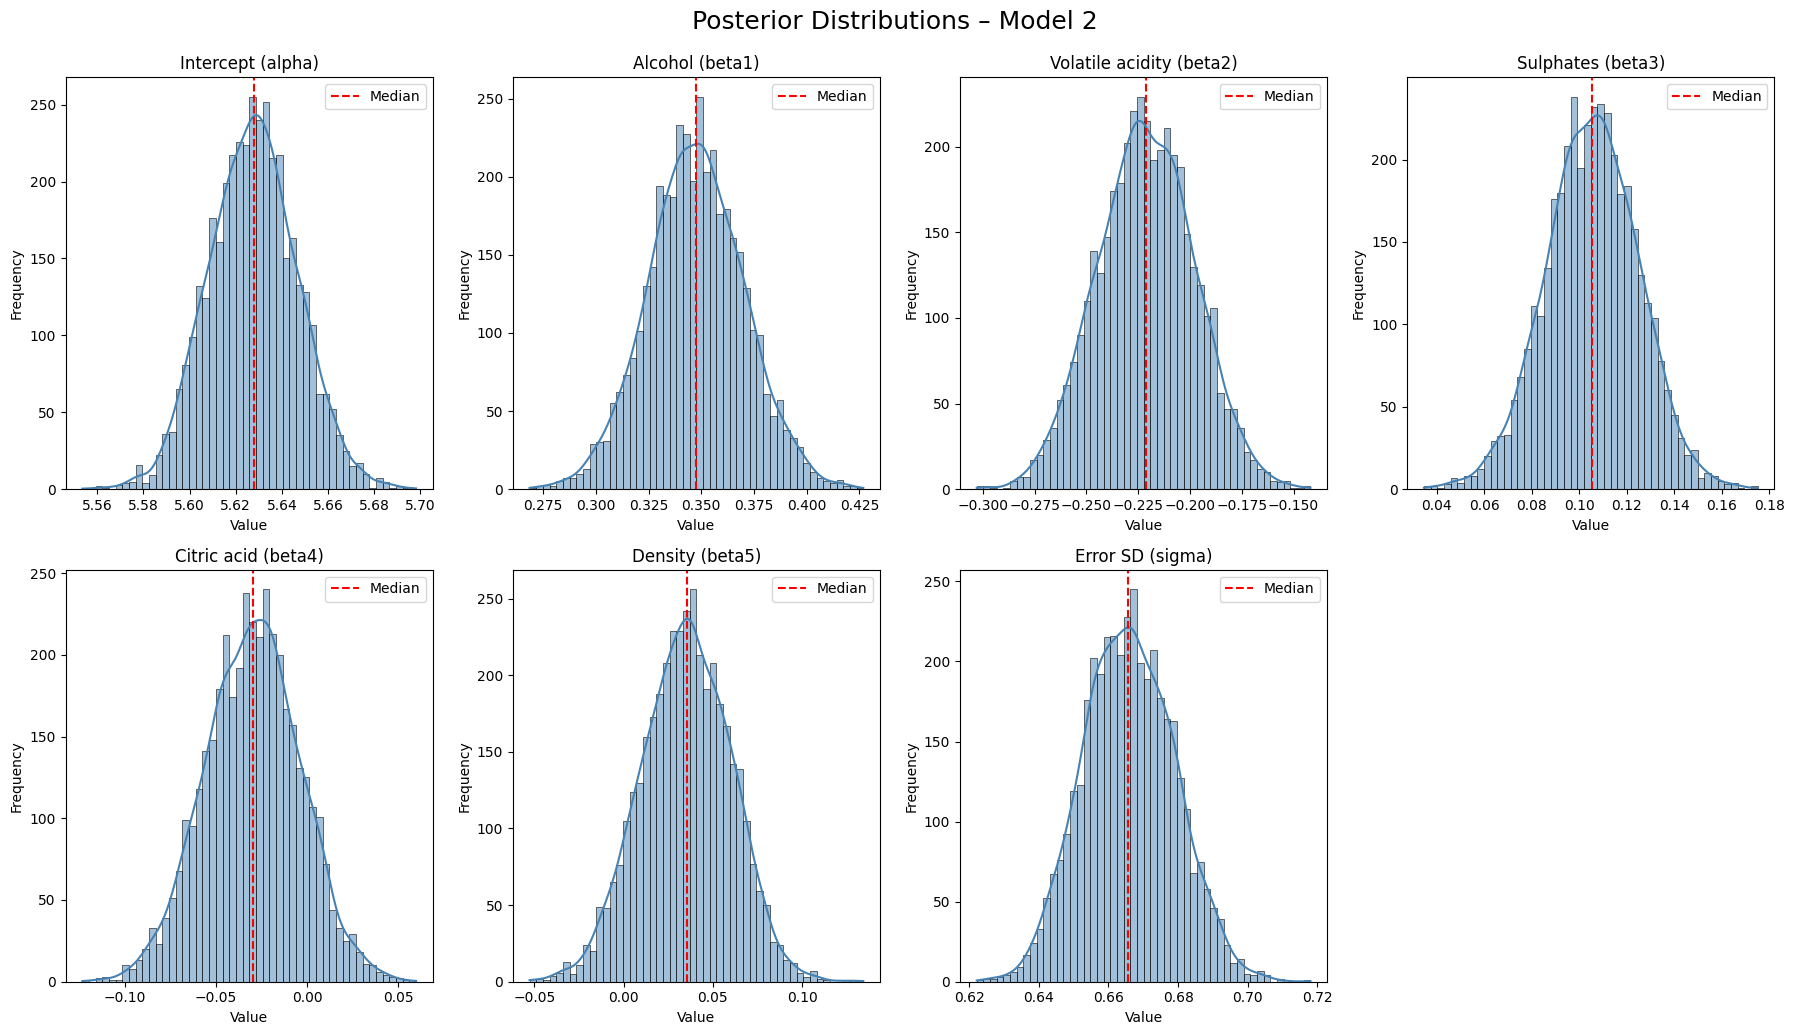

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Zakładamy, że fit2 to wynik modelu 2 (np. model1_4, model2_1 itd.)
posterior_df = fit2.draws_pd()

# Automatyczne wyciągnięcie nazw parametrów
param_names = [col for col in posterior_df.columns if col.startswith("alpha") or col.startswith("beta") or col == "sigma"]

# Przyjazne etykiety – dostosowane do 5 predyktorów
param_labels = {
    "alpha": "Intercept (alpha)",
    "beta[1]": "Alcohol (beta1)",
    "beta[2]": "Volatile acidity (beta2)",
    "beta[3]": "Sulphates (beta3)",
    "beta[4]": "Citric acid (beta4)",
    "beta[5]": "Density (beta5)",
    "sigma": "Error SD (sigma)"
}

# Tworzenie wykresów
plt.figure(figsize=(18, 10))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 4, i)
    sns.histplot(posterior_df[param], bins=50, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels.get(param, param))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 2", fontsize=18, y=1.03)
plt.show()


#### Posterior predictive check - model 2_1

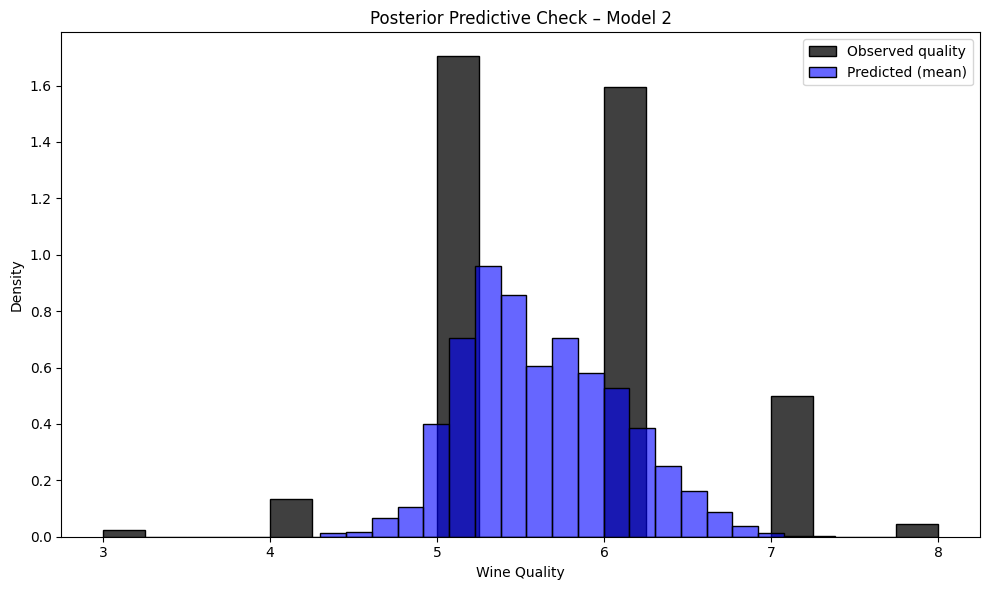

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Zakładamy, że fit2 to wynik Modelu 2
posterior_df = fit2.draws_pd()
alpha_samples = posterior_df["alpha"].values
sigma_samples = posterior_df["sigma"].values

# Wyciągnięcie beta[1] do beta[5]
beta_samples = posterior_df[[f"beta[{i}]" for i in range(1, 6)]].values

# Posterior predictive simulation
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_model2 @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Średnia predykcja z posteriora
y_pred_samples = np.array(y_pred_samples)
y_pred_mean = y_pred_samples.mean(axis=0)

# Wykres słupkowy (jak w Modelu 1_3)
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=20, color="black", label="Observed quality", stat="density")
sns.histplot(y_pred_mean, bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density")

plt.title("Posterior Predictive Check – Model 2")
plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


Posterior Predictive Check – TEST SET (Model 2):

Test sample #151


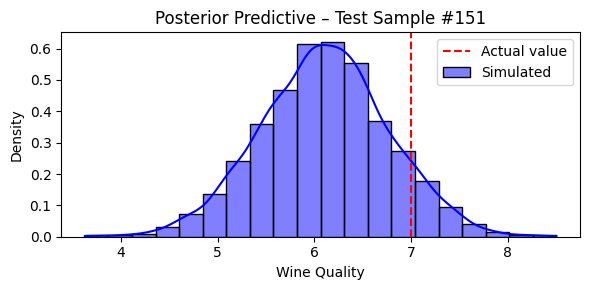

Test sample #175


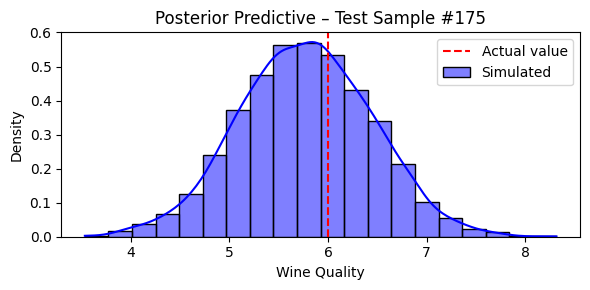

Test sample #298


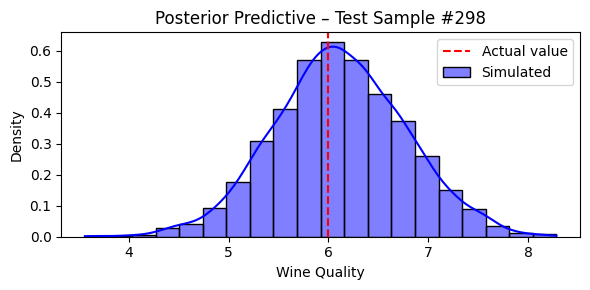

In [24]:
print("Posterior Predictive Check – TEST SET (Model 2):\n")

for i in range(3):
    idx = random.randint(0, len(X_test) - 1)
    print(f"Test sample #{idx}")

    mu_i = X_test[idx] @ beta_samples.T + alpha_samples
    y_sim_i = np.random.normal(mu_i, sigma_samples)

    plt.figure(figsize=(6, 3))
    sns.histplot(y_sim_i, bins=20, kde=True, color='blue', stat="density", label='Simulated')
    plt.axvline(y_test.iloc[idx], color='red', linestyle='--', label='Actual value')
    plt.title(f'Posterior Predictive – Test Sample #{idx}')
    plt.xlabel("Wine Quality")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
# Predykcja na TEST SET

y_pred_samples_test = []
for i in range(len(alpha_samples)):
    mu_test = X_test @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu_test, sigma_samples[i])
    y_pred_samples_test.append(y_sim)

y_pred_samples_test = np.array(y_pred_samples_test)
y_pred_mean_test = y_pred_samples_test.mean(axis=0)

accuracy_model2_test = np.mean(np.round(y_pred_mean_test) == np.round(y_test))
print(f"Accuracy (Model 2, on test set): {accuracy_model2_test:.3f}")

Accuracy (Model 2, on test set): 0.556


Compared to Model 1_3, the posterior predictive distribution of Model 2 shows slightly better spread and alignment with the observed data, particularly in the core quality range (5–6). However, both models continue to underestimate the tails, likely due to the use of continuous likelihood (Gaussian) for inherently discrete outcome values.

### Comparison of models

In order to keep progress of models, the copies of model1_3 and model2_1 were created: model1_3_loglik.stan and model2_1_loglik.

It was done to capture log-likelihood for each point of data.

In [27]:
from cmdstanpy import CmdStanModel

# Wczytaj model
model1_loglik = CmdStanModel(stan_file="projekt/models/model1_3_loglik.stan")

# Uruchom sampling (użyj tych samych danych co wcześniej)
fit1 = model1_loglik.sample(
    data=stan_data,   # dane do modelu 1 (np. 3 predyktory)
    chains=4,
    parallel_chains=4,
    seed=42
)

21:42:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:02 - cmdstanpy - INFO - CmdStan done processing.


In [28]:
# Wczytaj model
model2_loglik = CmdStanModel(stan_file="projekt/models/model2_1_loglik.stan")

# Sampling dla modelu 2 (np. z citric acid i density)
fit2 = model2_loglik.sample(
    data=stan_data2,  # dane do modelu 2 (5 predyktorów)
    chains=4,
    parallel_chains=4,
    seed=42
)

21:42:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:04 - cmdstanpy - INFO - CmdStan done processing.
21:42:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


#### Calculating WAIC and PSIS-LOO

In [29]:
import arviz as az

# Pobierz log_lik z CmdStan
log_lik_1 = fit1.stan_variable("log_lik")
log_lik_2 = fit2.stan_variable("log_lik")

# Utwórz obiekt InferenceData z log_likelihood (dla ArviZ)
idata1 = az.from_cmdstanpy(posterior=fit1, log_likelihood="log_lik")
idata2 = az.from_cmdstanpy(posterior=fit2, log_likelihood="log_lik")

# Oblicz WAIC i LOO
waic1 = az.waic(idata1)
waic2 = az.waic(idata2)

loo1 = az.loo(idata1)
loo2 = az.loo(idata2)

# Wyświetl wyniki
print("WAIC – Model 1:")
print(waic1)
print("\nWAIC – Model 2:")
print(waic2)

print("\nPSIS-LOO – Model 1:")
print(loo1)
print("\nPSIS-LOO – Model 2:")
print(loo2)


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC – Model 1:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1297.54    30.25
p_waic        6.50        -

There has been a warning during the calculation. Please check the results.

WAIC – Model 2:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1298.66    30.41
p_waic        8.75        -

There has been a warning during the calculation. Please check the results.

PSIS-LOO – Model 1:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1297.55    30.26
p_loo        6.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1279  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


PSIS-LOO – Model 2:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

 

#### Visual comparison of models

WAIC Comparison:


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Model 1,0,-1297.538349,6.504349,0.000000,1.000000e+00,30.254995,0.000000,True,log
Model 2,1,-1298.660687,8.750202,1.122338,1.110223e-16,30.409973,1.476174,True,log


<Figure size 800x400 with 0 Axes>

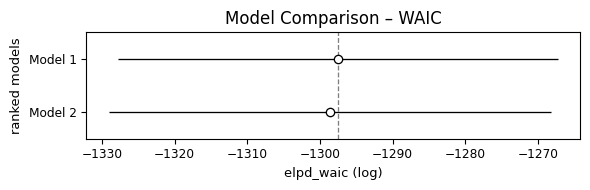

PSIS-LOO Comparison:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Model 1,0,-1297.550472,6.516473,0.000000,1.000000e+00,30.256043,0.000000,False,log
Model 2,1,-1298.674703,8.764218,1.124231,1.110223e-16,30.410848,1.476795,False,log


<Figure size 800x400 with 0 Axes>

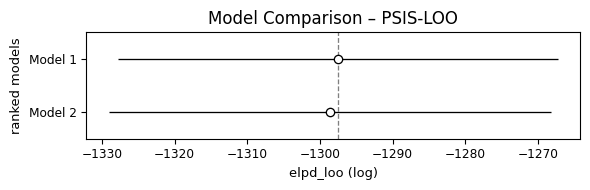

In [30]:
import arviz as az
import matplotlib.pyplot as plt

# Zbiór modeli do porównania
compare_dict = {"Model 1": idata1, "Model 2": idata2}

# --- 1. WAIC ---
waic_comparison = az.compare(compare_dict, ic="waic")
print("WAIC Comparison:")
display(waic_comparison)

plt.figure(figsize=(8, 4))
az.plot_compare(waic_comparison)
plt.title("Model Comparison – WAIC")
plt.tight_layout()
plt.show()

# --- 2. LOO ---
loo_comparison = az.compare(compare_dict, ic="loo")
print("PSIS-LOO Comparison:")
display(loo_comparison)

plt.figure(figsize=(8, 4))
az.plot_compare(loo_comparison)
plt.title("Model Comparison – PSIS-LOO")
plt.tight_layout()
plt.show()


## 4. Conculusions

## 5. Bibliography

[1] https://en.wikipedia.org/wiki/Wine_chemistry, date: 13.06.2025

[2] https://en.wikipedia.org/wiki/Acids_in_wine, date: 13.06.2025